In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import random
import json
import time
from tabulate import tabulate

from kdtree import *
from helper import *

In [7]:
savefile = "mst_data2.json"
to_plot = True
no_points = 1000
no_centres = 10

In [8]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate a moons dataset
X, y = make_moons(n_samples=no_points, noise=0.2, random_state=0)


In [9]:
# X, Y = make_blobs(n_samples=no_points, centers=no_centres, random_state=42)
points = [(x, y) for x, y in X]

In [10]:
cordmap = {point: i for i, point in enumerate(points)}

In [11]:
def dcran(cordmap):
    tree = KDTree()
    tree.root = tree.build(points)
    
    G = nx.Graph()
    for coord, index in cordmap.items():
        G.add_node(index, pos=coord)
    k = 2
    ccount = len(cordmap)
    disset , visited = set() , set()
    
    while ccount != 1:
        dis2 = min(len(cordmap) , math.factorial(k) )
        disset.update([k , dis2])
        disset = disset - visited
        visited.update([k , dis2])
        
        for kdis in sorted(list(disset)):
            for pointi, i in cordmap.items():
                pointj = ith_nearest_neighbor(tree, pointi, kdis)
                dis = euclidean_distance(pointi, pointj)
                G.add_edge(i, cordmap[pointj], weight=dis)
            graphify(G, to_plot )
            ccount = count_clusters(G)
            print(kdis, ccount)
        k += 1
        
        if ccount == 1:
            break
        
    return G , tree

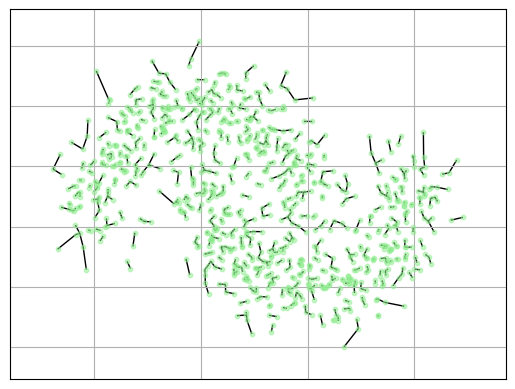

2 305


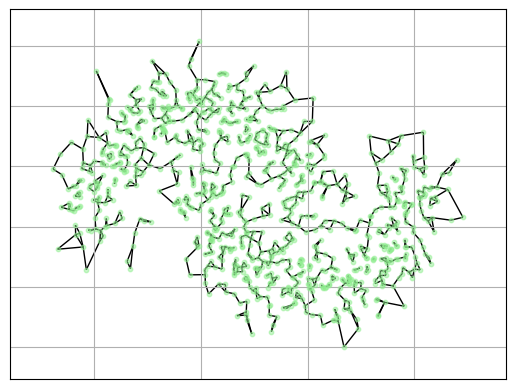

3 57


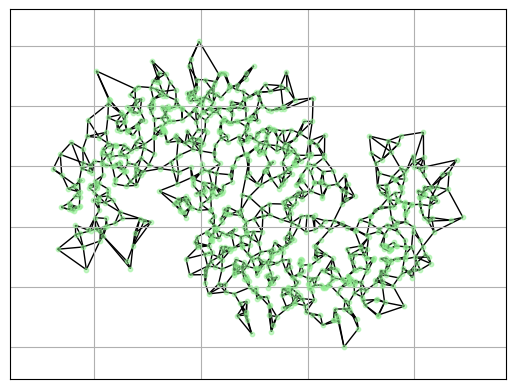

6 1


In [12]:
dcran_start_time = time.time()
kc , tree = dcran(cordmap)

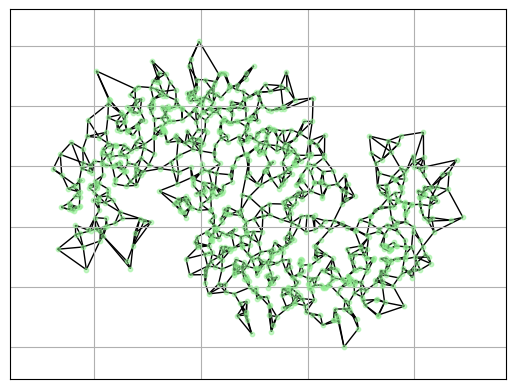

In [13]:
graphify(kc, to_plot )

In [14]:
G = kc
num_nodes = G.number_of_nodes()
conedge = num_edges = G.number_of_edges()

# Calculate the sum of all edge weights
total_weight = sum(data["weight"] for u, v, data in G.edges(data=True))

print(f"Total number of nodes: {num_nodes}")
print(f"Total number of edges: {num_edges}")
print(f"Total sum of edge weights: {total_weight}")

Total number of nodes: 1000
Total number of edges: 2131
Total sum of edge weights: 149.22339735400735


In [15]:

def plot_kd_tree(node, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    """Plot the kd-tree using matplotlib."""
    if node is None:
        return
    
    cur_point = node.point
    axis = node.axis

    if axis == 0:
        if branch is not None and prev_node is not None:
            if branch:
                max_y = prev_node.point[1]
            else:
                min_y = prev_node.point[1]
                
        plt.plot([cur_point[0], cur_point[0]], [min_y, max_y], 'r')
        plot_kd_tree(node.left, min_x, cur_point[0], min_y, max_y, node, True, depth + 1)
        plot_kd_tree(node.right, cur_point[0], max_x, min_y, max_y, node, False, depth + 1)

    elif axis == 1:
        if branch is not None and prev_node is not None:
            if branch:
                max_x = prev_node.point[0]
            else:
                min_x = prev_node.point[0]
                
        plt.plot([min_x, max_x], [cur_point[1], cur_point[1]], 'b')
        plot_kd_tree(node.left, min_x, max_x, min_y, cur_point[1], node, True, depth + 1)
        plot_kd_tree(node.right, min_x, max_x, cur_point[1], max_y, node, False, depth + 1)

    plt.plot(cur_point[0], cur_point[1], 'ko')

# Plotting


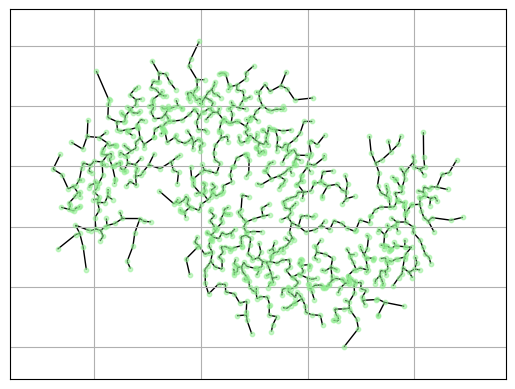

In [16]:
mst = nx.minimum_spanning_tree(G, algorithm="prim", weight="weight")
graphify(mst, to_plot )



In [17]:
G = mst
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()


foundw = total_weight = sum(data["weight"] for u, v, data in G.edges(data=True))

print(f"Total number of nodes: {num_nodes}")
print(f"Total number of edges: {num_edges}")
print(f"Total sum of edge weights: {total_weight}")
dcran_end_time = time.time()
dcran_elapsed_time = dcran_end_time - dcran_start_time

Total number of nodes: 1000
Total number of edges: 999
Total sum of edge weights: 50.10726522313413


In [18]:
stmst_start_time = time.time()
G = nx.Graph()

for pointi, i in cordmap.items():
    G.add_node(i, pos=pointi)
    for pointj, j in cordmap.items():
        if i != j:
            dis = euclidean_distance(pointi, pointj)
            G.add_edge(i, j, weight=dis)

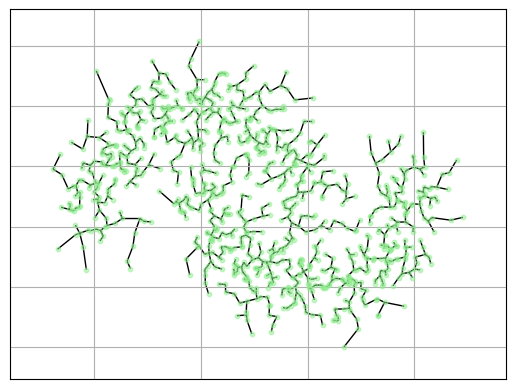

In [19]:
mst = nx.minimum_spanning_tree(G, algorithm="prim", weight="weight")
graphify(mst, to_plot  )

In [20]:
G = mst
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Calculate the sum of all edge weights
realw = total_weight = sum(data["weight"] for u, v, data in G.edges(data=True))

print(f"Total number of nodes: {num_nodes}")
print(f"Total number of edges: {num_edges}")
print(f"Total sum of edge weights: {total_weight}")
stmst_end_time = time.time()
stmst_elapsed_time = stmst_end_time - stmst_start_time

Total number of nodes: 1000
Total number of edges: 999
Total sum of edge weights: 49.24153925726305


In [21]:
percentage_error = ((foundw - realw) / realw) * 100

# Format the output for readability
formatted_output = f"Real Weight: {realw}  Found Weight: {foundw}  no of Edge: {conedge} Percentage Error: {percentage_error:.2f}%"
formatted_output

'Real Weight: 49.24153925726305  Found Weight: 50.10726522313413  no of Edge: 2131 Percentage Error: 1.76%'

In [22]:
with open(savefile, "r") as f:
    loaded_data = json.load(f)
print(loaded_data)
currres = []
speedup = round((stmst_elapsed_time  / dcran_elapsed_time) , 2)
loaded_data.append(
    [
        no_points,
        no_centres,
        foundw,
        realw,
        conedge,
        100 - percentage_error ,
        dcran_elapsed_time ,
        stmst_elapsed_time ,
        speedup
    ]
)

# Save the updated dictionary back to the JSON file
with open(savefile, "w") as f:
    json.dump(loaded_data, f)

[[1000, 10, 262.4419314705513, 258.819134723451, 8252, 98.6, 1.83, 4.38, 2.4], [10000, 10, 866.0209239473647, 865.3329904388614, 90645, 99.921, 28.58, 551.35, 19.29], [10000, 100, 1342.6324139702915, 1337.4478711909765, 27591, 99.612, 3.24, 510.53, 157.39], [10000, 100, 1342.6324139702915, 1337.4478711909762, 27591, 99.612, 2.48, 632.89, 255.22], [10000, 1000, 1459.7289235192638, 1455.1233116849917, 27457, 99.683, 2.5, 565.44, 226.17], [10000, 10, 866.0209239473647, 865.3329904388614, 90645, 99.92050071867081, 24.179672241210938, 617.7955191135406, 25.55], [10000, 50, 1260.1226131964793, 1255.8337705131123, 27661, 99.65848643474409, 2.1823902130126953, 513.3643357753754, 235.23], [10000, 10, 866.0209239473647, 865.3329904388614, 90645, 99.92050071867081, 24.11609435081482, 543.8352909088135, 22.55], [10000, 10, 875.7172119877604, 865.3329904388614, 38587, 98.79997392175785, 16.157432556152344, 646.0387144088745, 39.98], [10000, 100, 1342.6324139702872, 1337.4478711909717, 27591, 99.612

In [23]:
with open(savefile, "r") as f:
    loaded_data = json.load(f)
print(loaded_data)

[[1000, 10, 262.4419314705513, 258.819134723451, 8252, 98.6, 1.83, 4.38, 2.4], [10000, 10, 866.0209239473647, 865.3329904388614, 90645, 99.921, 28.58, 551.35, 19.29], [10000, 100, 1342.6324139702915, 1337.4478711909765, 27591, 99.612, 3.24, 510.53, 157.39], [10000, 100, 1342.6324139702915, 1337.4478711909762, 27591, 99.612, 2.48, 632.89, 255.22], [10000, 1000, 1459.7289235192638, 1455.1233116849917, 27457, 99.683, 2.5, 565.44, 226.17], [10000, 10, 866.0209239473647, 865.3329904388614, 90645, 99.92050071867081, 24.179672241210938, 617.7955191135406, 25.55], [10000, 50, 1260.1226131964793, 1255.8337705131123, 27661, 99.65848643474409, 2.1823902130126953, 513.3643357753754, 235.23], [10000, 10, 866.0209239473647, 865.3329904388614, 90645, 99.92050071867081, 24.11609435081482, 543.8352909088135, 22.55], [10000, 10, 875.7172119877604, 865.3329904388614, 38587, 98.79997392175785, 16.157432556152344, 646.0387144088745, 39.98], [10000, 100, 1342.6324139702872, 1337.4478711909717, 27591, 99.612

In [24]:
headers = [
    "Points",
    "Centres",
    "DCRAN Wt",
    "kruskal Wt",
    "Edge count",
    "Acc(%)",
    "DCRAN Time (s)",
    "STMST Time (s)",
    "Speedup"
]

# Format the data as a table using tabulate
table_str = tabulate(loaded_data[-10:], headers, tablefmt="pipe", floatfmt=(".0f", ".0f", ".1f", ".1f", ".0f", ".2f", ".2f", ".2f", ".2f"))
print(table_str)




|   Points |   Centres |   DCRAN Wt |   kruskal Wt |   Edge count |   Acc(%) |   DCRAN Time (s) |   STMST Time (s) |   Speedup |
|---------:|----------:|-----------:|-------------:|-------------:|---------:|-----------------:|-----------------:|----------:|
|      100 |        10 |       11.5 |         11.4 |          198 |    99.31 |             0.04 |             0.03 |      0.81 |
|      100 |        10 |       11.8 |         11.5 |          193 |    97.07 |             0.04 |             0.03 |      0.73 |
|     1000 |        10 |       29.3 |         29.1 |         5085 |    99.36 |             0.71 |             3.30 |      4.63 |
|    10000 |        10 |       93.1 |         93.0 |        60171 |    99.90 |            30.89 |           531.12 |     17.19 |
|      100 |        10 |       12.1 |         11.9 |          198 |    97.55 |             0.63 |             0.24 |      0.39 |
|     1000 |        10 |       28.3 |         28.2 |         5047 |    99.48 |             2.39 |

In [25]:
! notify-send "DCRAN" "Done"